**Two-dimensional histogram classification based on non-negative matrix factorization**  
Very preliminary version, as a first check/ proof-of-principle.  
Need to pay more attention to definition of training and testing set(s) and hyperparameters.

In [22]:
### imports

# external modules
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import dataframe_utils as dfu
import plot_utils as pu
import hist_utils as hu
import generate_data_2d_utils as g2u
import json_utils as jsonu
importlib.reload(csvu)
importlib.reload(dfu)
importlib.reload(pu)
importlib.reload(hu)
importlib.reload(g2u)
importlib.reload(jsonu)
sys.path.append('../src/classifiers')
import NMFClassifier
importlib.reload(NMFClassifier)
sys.path.append('../omsinterface')
from get_oms_data import get_oms_data

number of lumisections: 599
number of lumisections: 185
number of lumisections: 15


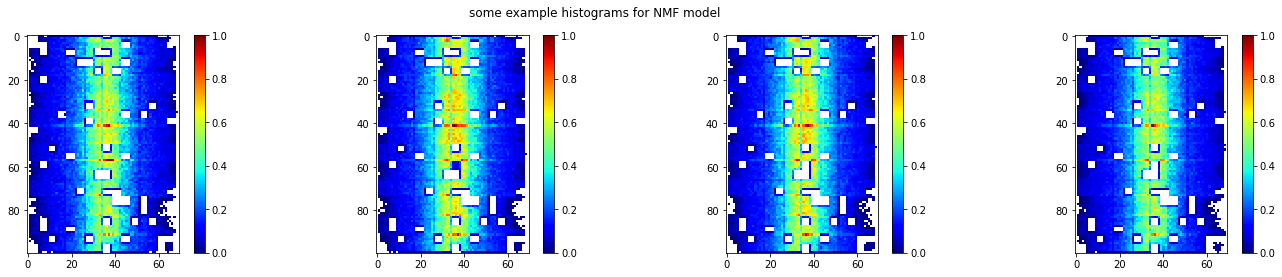

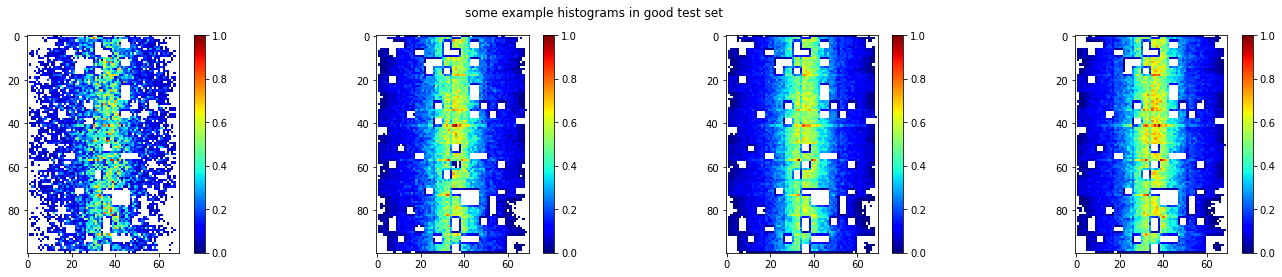

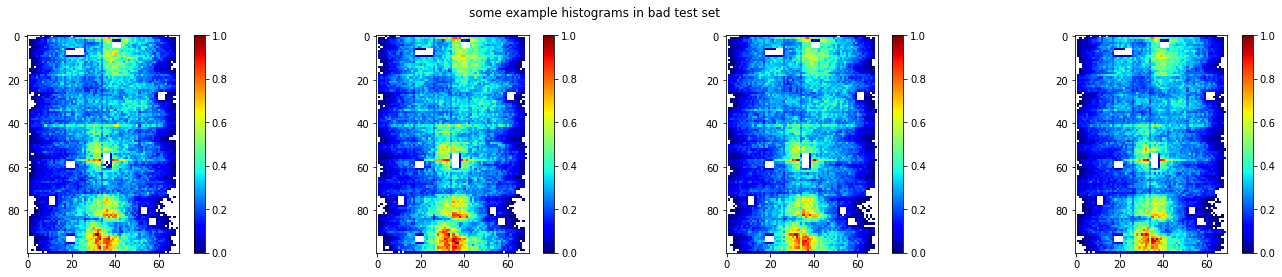

In [23]:
### load the histograms

# note: you might need to change the path or file name, depending on where you have a valid csv file stored!
dffile = '../data/DF2017B_clusterposition_zphi_ontrack_PXLayer_1_subset.csv'
histdf = csvu.read_csv(dffile)
histdf = dfu.select_dcson(histdf)
(hists_ref) = hu.preparedatafromdf(histdf, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_ref[:4], ncols=4, title='some example histograms for NMF model')
print('number of lumisections: '+str(len(histdf)))

dffile = '../data/DF2017B_clusterposition_zphi_ontrack_PXLayer_1_run297056.csv'
histdf = csvu.read_csv(dffile)
histdf = dfu.select_dcson(histdf)
(hists_good, runnbs_good, lsnbs_good) = hu.preparedatafromdf(histdf, returnrunls=True, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_good[:4], ncols=4, title='some example histograms in good test set')
print('number of lumisections: '+str(len(histdf)))

dffile = '../data/DF2017B_clusterposition_zphi_ontrack_PXLayer_1_run297289.csv'
histdf = csvu.read_csv(dffile)
histdf = dfu.select_dcson(histdf)
(hists_bad, runnbs_bad, lsnbs_bad) = hu.preparedatafromdf(histdf, returnrunls=True, cropslices=[slice(1,-1,None),slice(81,221,None)], rebinningfactor=(2,2), donormalize=True, doplot=False)
_ = pu.plot_hists_2d(hists_bad[:4], ncols=4, title='some example histograms in bad test set')
print('number of lumisections: '+str(len(histdf)))

In [24]:
### build an NMF model

classifier = NMFClassifier.NMFClassifier( hists_ref, ncomponents=10 )

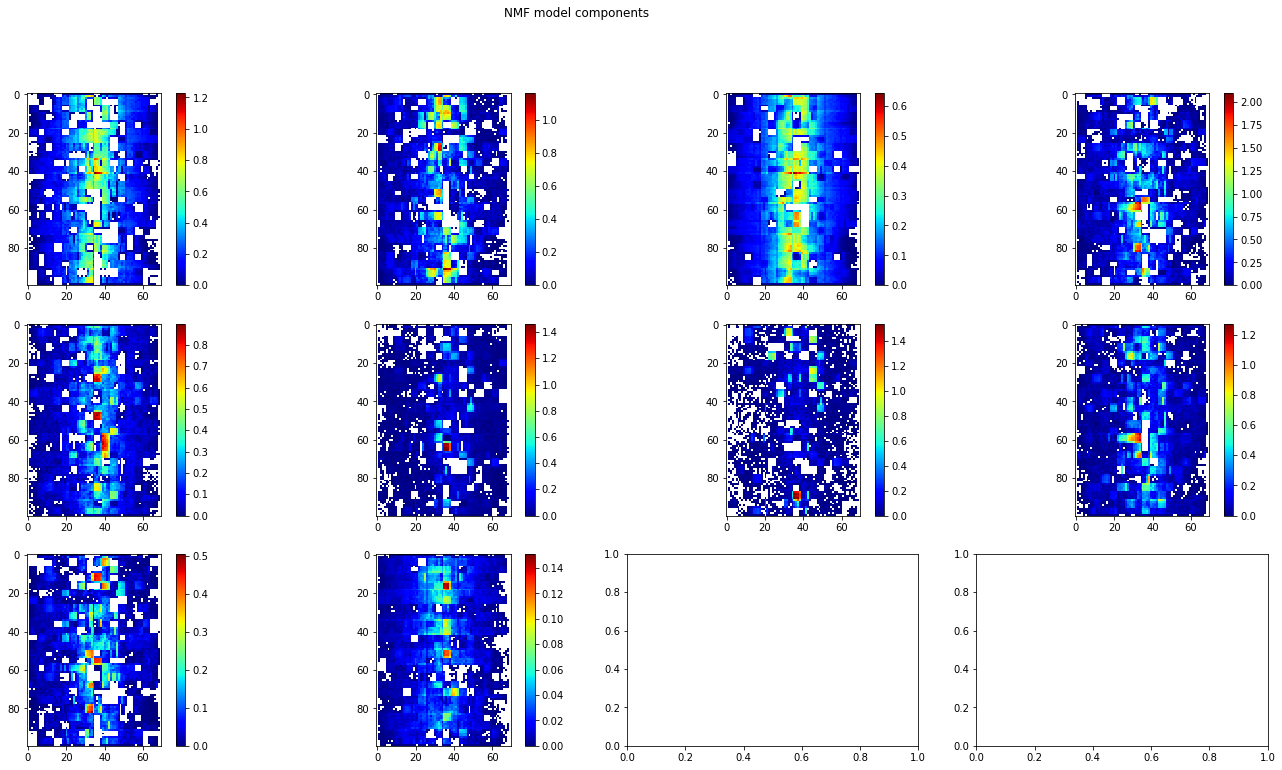

In [25]:
### plot some of the components

components = classifier.getcomponents()
_ = pu.plot_hists_2d(components, ncols=4, title='NMF model components')

In [26]:
### optionally enlarge the test set using resampling

do_resampling = True

if do_resampling:
    hists_good_ext = g2u.fourier_noise_nd(hists_good, nresamples=4, nonnegative=True, 
                     stdfactor=10., kmaxscale=0.5, ncomponents=3)
    print(hists_good_ext.shape)
    hists_bad_ext = g2u.fourier_noise_nd(hists_bad, nresamples=40, nonnegative=True, stdfactor=5., kmaxscale=0.5, ncomponents=3)
    print(hists_bad_ext.shape)

(740, 100, 70)
(600, 100, 70)


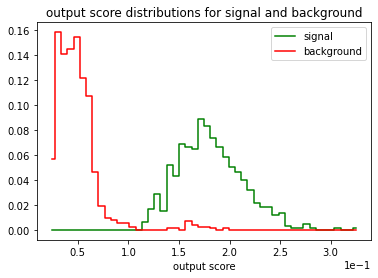

In [27]:
### perform the classification

hists_good_appl = hists_good
hists_bad_appl = hists_bad
if do_resampling:
    hists_good_appl = hists_good_ext
    hists_bad_appl = hists_bad_ext
    
scores_good = classifier.evaluate( hists_good_appl, nmax=50 )
labels_good = np.zeros(len(scores_good))
scores_bad = classifier.evaluate( hists_bad_appl, nmax=50 )
labels_bad = np.ones(len(scores_bad))
scores = np.concatenate((scores_good,scores_bad))
labels = np.concatenate((labels_good,labels_bad))
_ = pu.plot_score_dist( scores, labels, nbins=50, normalize=True,
                        title='output score distributions for signal and background',
                        xaxtitle='output score', yaxtitle=None)

example histograms from good test set:


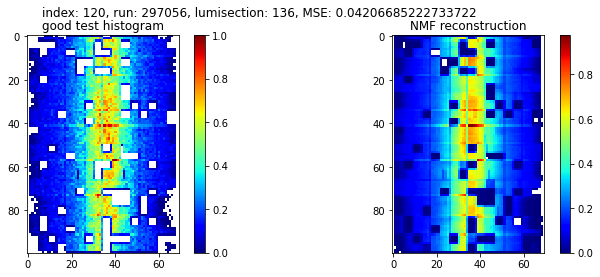

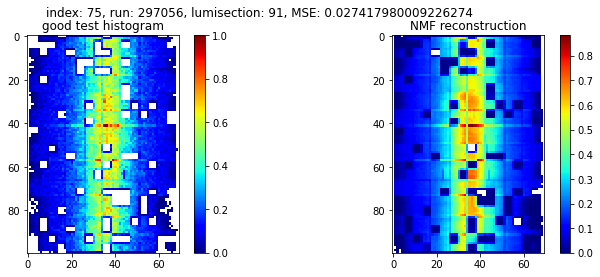

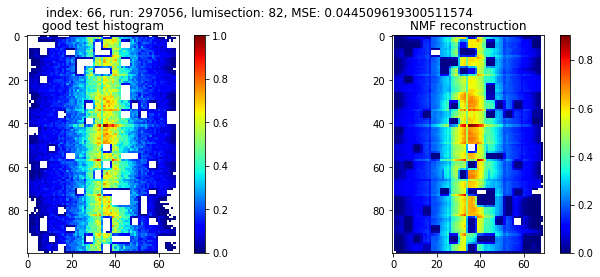

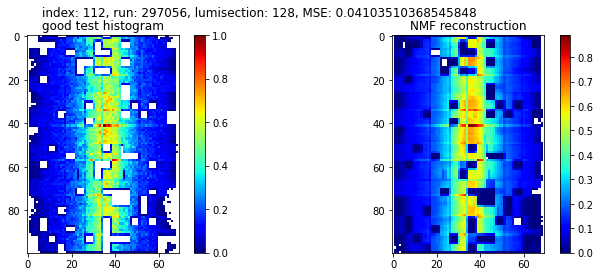

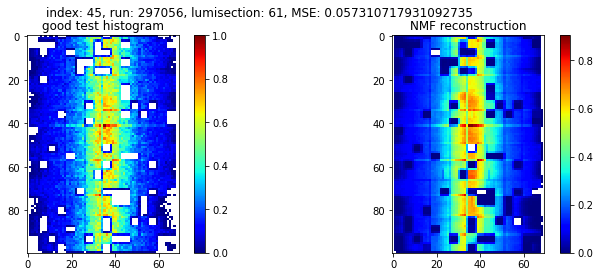

example histograms from bad test set:


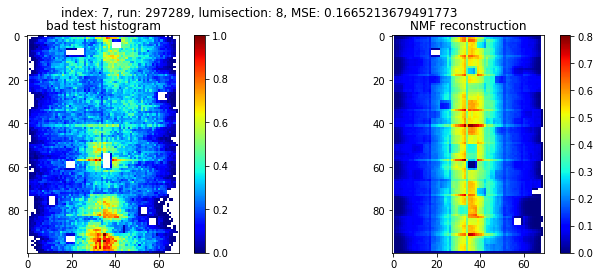

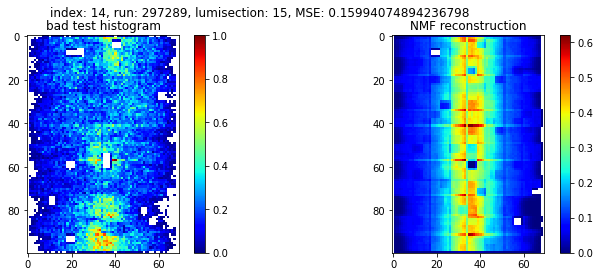

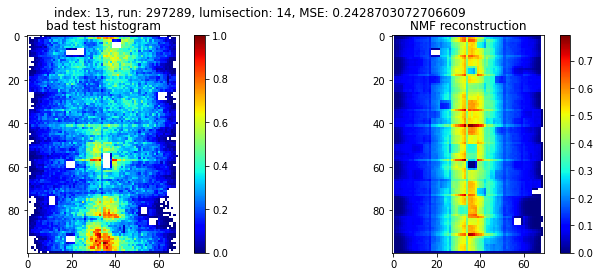

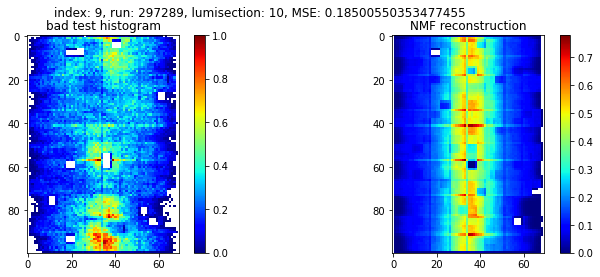

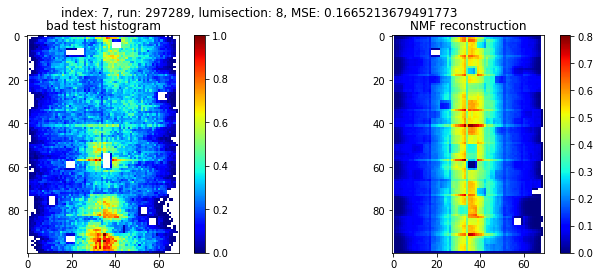

In [28]:
### check some examples

nplot = 5

inds_good = np.random.choice(np.array(list(range(len(hists_good)))),size=nplot)
print('example histograms from good test set:')
for i in inds_good:
    histlist = [hists_good[i],classifier.reconstruct(np.array([hists_good[i]]))[0]]
    subtitles = ['good test histogram','NMF reconstruction']
    title = 'index: {}, run: {}, lumisection: {}, MSE: {}'.format(i, runnbs_good[i],lsnbs_good[i],scores_good[i])
    pu.plot_hists_2d(histlist, ncols=2, title = title, subtitles=subtitles, xaxtitle=None, yaxtitle=None)
plt.show()

inds_bad = np.random.choice(np.array(range(len(hists_bad))),size=nplot)
print('example histograms from bad test set:')
for i in inds_bad:
    histlist = [hists_bad[i],classifier.reconstruct(np.array([hists_bad[i]]))[0]]
    subtitles = ['bad test histogram','NMF reconstruction']
    title = 'index: {}, run: {}, lumisection: {}, MSE: {}'.format(i, runnbs_bad[i],lsnbs_bad[i],scores_bad[i])
    pu.plot_hists_2d(histlist, ncols=2, title = title, subtitles=subtitles, xaxtitle=None, yaxtitle=None)
plt.show()

In [39]:
### extra: retrieve information from OMS on pileup, lumi and/or trigger rates

# pileup and luminosity in good test set
oms_target_run_good = 297056
ls_info_good = get_oms_data( 'lumisections', oms_target_run_good, authmode='login' )
# pileup and luminosity in bad test set
oms_target_run_bad = 297289
ls_info_bad = get_oms_data( 'lumisections', oms_target_run_bad, authmode='login')

Enter CERN username:llambrec
Enter CERN password: ········
obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

Total number of lumisections: 212                                                                   



Enter CERN username:llambrec
Enter CERN password: ········
obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

obtaining cookies for https://cmsoms.cern.ch/agg/api/v1/ from provided login for username llambrec ...


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/

Total number of lumisections: 26





/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/urllib3/connectionpool.py:846: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn((


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'luminosity for bad run'}, xlabel='lumisection number', ylabel='luminosity'>)

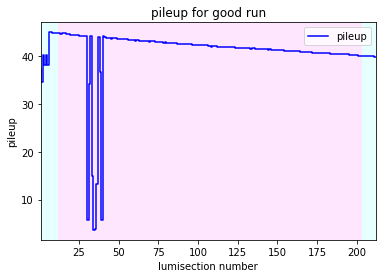

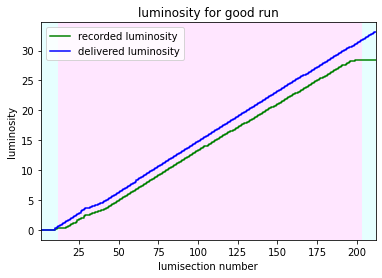

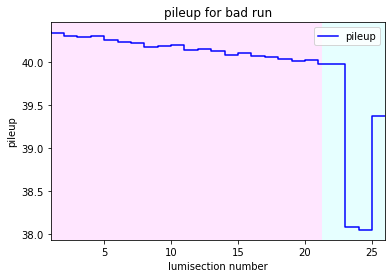

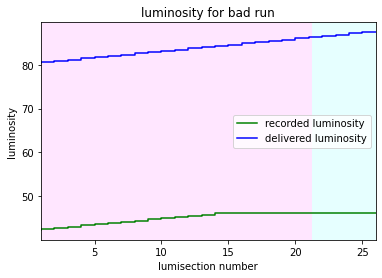

In [40]:
### make plots of OMS info

# plots for good run
ls_good = [el['lumisection_number'] for el in ls_info_good]
dcson_good = jsonu.isdcson( [oms_target_run_good]*len(ls_good), ls_good )
pileup_good = [el['pileup'] for el in ls_info_good]
lumi_rec_good = [el['recorded_lumi'] for el in ls_info_good]
lumi_del_good = [el['delivered_lumi'] for el in ls_info_good]
pu.plot_hists([pileup_good], colorlist=['b'], labellist=['pileup'], xlims=(ls_good[0],ls_good[-1]),
              title='pileup for good run', xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=dcson_good,bkgcmap='cool')
pu.plot_hists([lumi_rec_good,lumi_del_good], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'], xlims=(ls_good[0],ls_good[-1]),
              title='luminosity for good run', xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=dcson_good,bkgcmap='cool')

ls_bad = [el['lumisection_number'] for el in ls_info_bad]
dcson_bad = jsonu.isdcson( [oms_target_run_bad]*len(ls_bad), ls_bad )
pileup_bad = [el['pileup'] for el in ls_info_bad]
lumi_rec_bad = [el['recorded_lumi'] for el in ls_info_bad]
lumi_del_bad = [el['delivered_lumi'] for el in ls_info_bad]
pu.plot_hists([pileup_bad], colorlist=['b'], labellist=['pileup'], xlims=(ls_bad[0],ls_bad[-1]),
              title='pileup for bad run', xaxtitle='lumisection number', yaxtitle='pileup',
              bkgcolor=dcson_bad,bkgcmap='cool')
pu.plot_hists([lumi_rec_bad,lumi_del_bad], colorlist=['g','b'], labellist=['recorded luminosity','delivered luminosity'], xlims=(ls_bad[0],ls_bad[-1]),
              title='luminosity for bad run', xaxtitle='lumisection number', yaxtitle='luminosity',
              bkgcolor=dcson_bad,bkgcmap='cool')

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38]
[9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


(<Figure size 1728x1152 with 31 Axes>,
 array([[<AxesSubplot:title={'center':'lumisection: 25, pileup: 44.36963654'}>,
         <AxesSubplot:title={'center':'lumisection: 26, pileup: 44.32398224'}>,
         <AxesSubplot:title={'center':'lumisection: 27, pileup: 44.28007889'}>,
         <AxesSubplot:title={'center':'lumisection: 28, pileup: 44.26522827'}>],
        [<AxesSubplot:title={'center':'lumisection: 29, pileup: 44.24317932'}>,
         <AxesSubplot:title={'center':'lumisection: 30, pileup: 44.18254471'}>,
         <AxesSubplot:title={'center':'lumisection: 31, pileup: 5.74658823'}>,
         <AxesSubplot:title={'center':'lumisection: 32, pileup: 34.22814941'}>],
        [<AxesSubplot:title={'center':'lumisection: 33, pileup: 44.17366791'}>,
         <AxesSubplot:title={'center':'lumisection: 34, pileup: 14.83295727'}>,
         <AxesSubplot:title={'center':'lumisection: 35, pileup: 3.64267182'}>,
         <AxesSubplot:title={'center':'lumisection: 36, pileup: 3.75829291'}>],
 

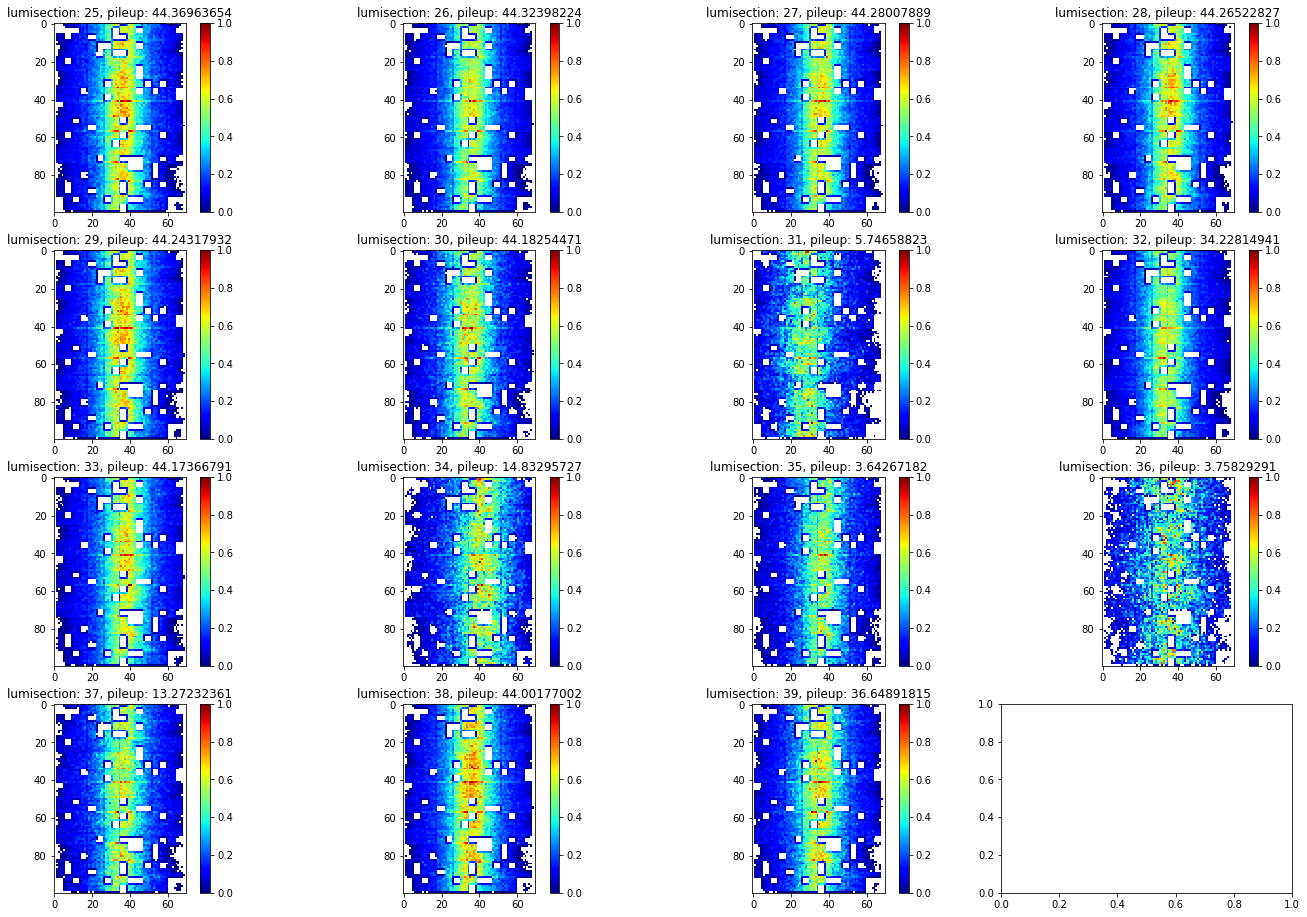

In [46]:
### plot particular lumisections based on the OMS info above

lsnbs_tocheck = list(range(25,40))
idx_oms = [np.where(np.array(ls_good)==lsnb)[0][0] for lsnb in lsnbs_tocheck]
idx_hist = [np.where(lsnbs_good==lsnb)[0][0] for lsnb in lsnbs_tocheck]
print(idx_oms)
print(idx_hist)
histlist = [hists_good[i] for i in idx_hist]
subtitles = ['lumisection: {}, pileup: {}'.format(lsnbs_tocheck[i],ls_info_good[idx_oms[i]]['pileup']) for i in range(len(lsnbs_tocheck))]
pu.plot_hists_2d(histlist, subtitles=subtitles)